# Single-source Friedman experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import torch 
import torch.nn as nn
from matplotlib.pyplot import cm
from models.hdisc_msda import Disc_MSDANet, weighted_mse
from utils.utils_hdisc import batch_loader, split_source_target, val_split
from sklearn.manifold import TSNE
from utils.toy_friedman import friedman, generate_x_friedman, generate_y_friedman


## Data

In [2]:
N = 200
n_domains = 10
X = np.zeros((n_domains, N, 5))
alpha = np.ones(n_domains-1)/(n_domains-1)

X = generate_x_friedman(n_domains = 10, N = 100, alpha = np.ones(9)/9, noise=0.2,
                        target_shift_mean=0.5, target_shift_std=0.5, random_state = 0)
y = generate_y_friedman(X, normalize = True, random_state = 0)



In [3]:
def generate_x_friedman_clusters(n_domains = 10, N = 100, alpha = np.ones(9)/9, clusters=None, noise=0.1, cluster_noise=0.1,
                                 target_shift_mean=0, target_shift_std=0, random_state=0):
    """
    Generates source input X according to normal distribution centered on 1 or -1 for every feature and target input as a
    combination of the inputs with a shift
    Inputs:
        - n_domains: number of domains to generate
        - N: number of samples in each domain
        - alpha: weight of each source to generate the target distribution
        - target_shift_mean: mean on each shift of the target X[:,f]
        - target_shift_std: std on each shift of the target X[:,f]
    """
    assert len(alpha)==n_domains-1
    if random_state is not None:
        np.random.seed(random_state)
    if clusters is None:
        clusters = np.arange(len(clusters))
    n_clusters = len(clusters)
    
    X = np.zeros((n_domains, N, 5))
    rest = N - np.sum([int(alpha[n]*N) for n in range(n_domains-1)])
    idx = np.random.choice(np.where(alpha!=0)[0], rest)
    counts = np.zeros(n_domains-1).astype('int')
    for i in idx:
        counts[i] = counts[i]+1
    j=0
    mu_clusters = np.array([[np.random.choice([-1,1]) for f in range(5)] for k in range(n_clusters)])
    #mu_clusters = np.array([np.ones(5), -np.ones(5), np.array([1,-1,1,-1,1])])
    for n in range(n_domains-1):
        for f in range(5):
            mu = mu_clusters[clusters[n], f]+np.random.randn()*cluster_noise
            X[n, :, f] = mu + np.random.randn(N)*noise
            X[n_domains-1, j:j+int(alpha[n]*N),f] = mu+target_shift_mean+np.random.randn()*target_shift_std + np.random.randn(int(alpha[n]*N))*noise
            X[n_domains-1, j+int(alpha[n]*N):j+int(alpha[n]*N)+counts[n],f] = mu+target_shift_mean+np.random.randn()*target_shift_std + np.random.randn(counts[n])*noise
        j = j+int(alpha[n]*N)+counts[n]
    return X 


N = 100
n_domains = 10
X = np.zeros((n_domains, N, 5))
alpha = np.array([1,1,1,1,1,1,1,1,1])
alpha = alpha/np.sum(alpha)
clusters = np.array([0,0,0,1,1,1,2,2,2])

X = generate_x_friedman_clusters(n_domains = 10, N = 100, alpha = alpha, noise=0.2, clusters = clusters, cluster_noise=0,
                        target_shift_mean=0.3, target_shift_std=0.3, random_state = 10)
y = generate_y_friedman(X, normalize = True, random_state = 0, eps=0)


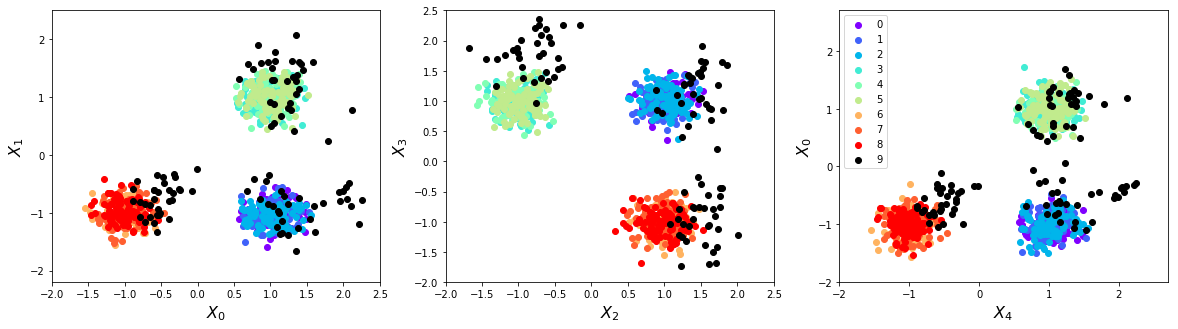

In [4]:
plt.figure(figsize=(20,5))
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,1)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,0], X[i,:,1], c=c, label=str(i))
    plt.xlabel('$X_0$', fontsize=16)
    plt.ylabel('$X_1$', fontsize=16)
plt.scatter(X[-1,:,0], X[-1,:,1], c='k', label=str(9))
plt.xlim(-2,2.5)
plt.ylim(-2.2,2.5)
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,2)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,2], X[i,:,3], c=c, label=str(i))
    plt.xlabel('$X_2$', fontsize=16)
    plt.ylabel('$X_3$', fontsize=16)
plt.scatter(X[-1,:,2], X[-1,:,3], c='k', label=str(9))
plt.xlim(-2,2.5)
plt.ylim(-2,2.5)
color=iter(cm.rainbow(np.linspace(0,1,n_domains-1)))
plt.subplot(1,3,3)
for i in range(n_domains-1):
    c=next(color)
    plt.scatter(X[i,:,0], X[i,:,4], c=c, label=str(i))
    plt.xlabel('$X_4$', fontsize=16)
    plt.ylabel('$X_0$', fontsize=16)
plt.scatter(X[-1,:,0], X[-1,:,4], c='k', label=str(9))
plt.xlim(-2,2.7)
plt.ylim(-2,2.7)

plt.legend()
plt.savefig('./plots/friedman/single_source_data.jpg', transparent=True)
plt.show()


## Experiments

### Basic Models

In [5]:
def get_feature_extractor():
    return nn.ModuleList([
            nn.Linear(5, 20, bias=False), nn.ELU(),

            nn.Linear(20, 5, bias=False)])

def get_predictor(output_dim=1):
    return  nn.ModuleList([
            nn.Linear(5, output_dim, bias=False)])

def get_discriminator(output_dim=1):
    return nn.ModuleList([
            nn.Linear(5, output_dim, bias=False)])


In [6]:
full_logs = {}
full_feats = {}
full_w = {}

### 1. No adaptation

In [7]:
mode = 'MLP'
seed = 42
#Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
#Parameters of training
epochs = 150
device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True

#Model
params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
params['feature_extractor'] = get_feature_extractor()
params['h_pred'] = get_predictor(output_dim=1)
params['h_disc'] = get_discriminator(output_dim=1)
clip = 1
target = n_domains - 1

#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
model = Disc_MSDANet(params).to(device)
opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_pred = torch.optim.SGD([{'params': model.h_pred.parameters()}],lr=lr, momentum=momentum)
opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
#Logs
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
for epoch in range(epochs):
    model.train()
    loader = batch_loader(X_train, y_train ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        loss_pred = model.train_prediction(x_bs, X_t, y_bs, clip=clip, pred_only=False)
        #model.train_h_disc_pred(x_bs, X_t, y_bs, clip=clip)
    #Validation
    model.eval()
    val_loss, _ = model.compute_loss(X_val, X_t, y_val)
    source_loss, disc = model.compute_loss(X_s, X_t, y_s)
    reg_loss = model.loss(y_t, model.predict(X_t))
    reg_train_loss.append(source_loss.item())
    reg_test_loss.append(reg_loss.item())
    reg_val_loss.append(val_loss.item())
    
    if (val_loss.item()<current_val_loss)*(keep_best):
        current_val_loss = val_loss.item()
        best_mse = model.loss(y_t, model.predict(X_t))
    if (epoch+1)%10==0:
        model.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs, source_loss.item(), val_loss.item(), reg_loss.item()))

full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(model.h_pred.parameters())[0]

Epoch: 10/150 ; Train loss: 1.014 ; Validation loss: 1.181 Test loss: 0.600
Epoch: 20/150 ; Train loss: 0.779 ; Validation loss: 0.927 Test loss: 0.475
Epoch: 30/150 ; Train loss: 0.551 ; Validation loss: 0.676 Test loss: 0.373
Epoch: 40/150 ; Train loss: 0.331 ; Validation loss: 0.427 Test loss: 0.311
Epoch: 50/150 ; Train loss: 0.158 ; Validation loss: 0.217 Test loss: 0.351
Epoch: 60/150 ; Train loss: 0.118 ; Validation loss: 0.150 Test loss: 0.494
Epoch: 70/150 ; Train loss: 0.118 ; Validation loss: 0.151 Test loss: 0.504
Epoch: 80/150 ; Train loss: 0.117 ; Validation loss: 0.154 Test loss: 0.482
Epoch: 90/150 ; Train loss: 0.117 ; Validation loss: 0.154 Test loss: 0.482
Epoch: 100/150 ; Train loss: 0.117 ; Validation loss: 0.153 Test loss: 0.484
Epoch: 110/150 ; Train loss: 0.116 ; Validation loss: 0.152 Test loss: 0.484
Epoch: 120/150 ; Train loss: 0.116 ; Validation loss: 0.152 Test loss: 0.484
Epoch: 130/150 ; Train loss: 0.116 ; Validation loss: 0.152 Test loss: 0.484
Epoch: 1

### 2. H-disc

In [8]:
mode = 'AHDA'
#Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True

#Parameters of training
epochs_adapt = 150
epochs_h_disc, epochs_feat, epochs_pred = 1, 1, 1
device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True

#Model
params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
params['feature_extractor'] = get_feature_extractor()
params['h_pred'] = get_predictor(output_dim=1)
params['h_disc'] = get_discriminator(output_dim=1)
clip = 1
target = n_domains - 1

disc_adapt = []

#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
model = Disc_MSDANet(params).to(device)
opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
opt_pred = torch.optim.SGD([{'params': model.h_pred.parameters()}],lr=lr, momentum=momentum)
opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
#Logs
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
#Alternated training
print('------------Alternated training------------')
for epoch in range(epochs_adapt):
    model.train()
    loader = batch_loader(X_s, y_s ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        ridx = np.random.choice(X_t.shape[0], batch_size)
        x_bt = X_t[ridx,:]
        #Train h to minimize source loss
        for e in range(epochs_pred):
            model.train_prediction(x_bs, x_bt, y_bs, pred_only=True,clip=clip)

        #Train h' to maximize discrepancy
        for e in range(epochs_h_disc):
            model.train_h_discrepancy(x_bs, x_bt, y_bs, clip=clip)

        #Train phi to minimize discrepancy
        for e in range(epochs_feat):
            model.train_feat_discrepancy(x_bs, x_bt, y_bs, mu=0.01,clip=clip)


    #Validation
    model.eval()
    val_loss, _ = model.compute_loss(X_val, X_t, y_val)
    source_loss, disc = model.compute_loss(X_s, X_t, y_s)
    reg_loss = model.loss(y_t, model.predict(X_t))
    reg_train_loss.append(source_loss.item())
    reg_test_loss.append(reg_loss.item())
    reg_val_loss.append(val_loss.item())
    disc_adapt.append(disc.item())
    if (val_loss.item()<current_val_loss)*(keep_best):
        current_val_loss = val_loss.item()
        best_mse = model.loss(y_t, model.predict(X_t))
    if (epoch+1)%10==0:
        model.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), reg_loss.item()))

full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(model.h_pred.parameters())[0]


------------Alternated training------------
Epoch: 10/150 ; Train loss: 0.991 ; Validation loss: 1.076 Test loss: 0.634
Epoch: 20/150 ; Train loss: 0.922 ; Validation loss: 1.003 Test loss: 0.597
Epoch: 30/150 ; Train loss: 0.858 ; Validation loss: 0.936 Test loss: 0.558
Epoch: 40/150 ; Train loss: 0.802 ; Validation loss: 0.877 Test loss: 0.522
Epoch: 50/150 ; Train loss: 0.745 ; Validation loss: 0.817 Test loss: 0.488
Epoch: 60/150 ; Train loss: 0.685 ; Validation loss: 0.754 Test loss: 0.458
Epoch: 70/150 ; Train loss: 0.629 ; Validation loss: 0.695 Test loss: 0.428
Epoch: 80/150 ; Train loss: 0.575 ; Validation loss: 0.637 Test loss: 0.402
Epoch: 90/150 ; Train loss: 0.518 ; Validation loss: 0.577 Test loss: 0.379
Epoch: 100/150 ; Train loss: 0.467 ; Validation loss: 0.523 Test loss: 0.360
Epoch: 110/150 ; Train loss: 0.422 ; Validation loss: 0.475 Test loss: 0.344
Epoch: 120/150 ; Train loss: 0.378 ; Validation loss: 0.427 Test loss: 0.335
Epoch: 130/150 ; Train loss: 0.342 ; Vali

### 3. DANN

In [9]:
from models.MDAN import MDANet_general
import torch.nn.functional as F
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True

mode = 'DANN'

configs = {"num_epochs": 200, "num_domains": 9, 
           "mode": 'DANN', "verbose": 2}

device = torch.device('cuda:0')
lr, momentum = 0.001, 0.9
batch_size = 32
keep_best = True
epochs = 150

#Hyperparameters
mu = 1
gamma = 5
mode = configs['mode']
#Split source and target
X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
#Validation split
X_train, X_val, y_train, y_val = val_split(X_s, y_s)
#Initialize model
configs['hiddens'] = get_feature_extractor()
configs['predictor'] = get_predictor(output_dim=1)
configs['discriminator'] = [get_discriminator(output_dim=2) for _ in range(configs['num_domains'])]
mdan = MDANet_general(configs).to(device)
reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
current_val_loss = np.inf
#Alternated training
for i in range(configs['num_domains']):
    mdan.discriminator[i].to(device)
optimizer = torch.optim.SGD(mdan.parameters(), lr=lr, momentum=momentum)
for epoch in range(epochs):
    mdan.train()
    loader = batch_loader(X_train, y_train ,batch_size = batch_size)
    for x_bs, y_bs in loader:
        slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
        tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
        ridx = np.random.choice(X_t.shape[0], batch_size)
        #Batch selection of X_t
        tinputs = X_t[ridx, :]
        optimizer.zero_grad()
        vals, sdomains, tdomains = mdan(x_bs, tinputs)
        # Compute prediction accuracy on multiple training sources.
        losses = torch.stack([F.mse_loss(vals[j], y_bs[j]) for j in range(configs['num_domains'])])
        domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                   F.nll_loss(tdomains[j], tlabels) for j in range(configs['num_domains'])])
        # Different final loss function depending on different training modes.
        loss = torch.mean(losses) + mu * torch.mean(domain_losses)
        loss.backward(retain_graph=True)
        optimizer.step()
    mdan.eval()
    preds_labels = mdan.inference(X_t)
    source_loss = torch.mean(torch.stack([torch.nn.MSELoss()(y_train[i], mdan.inference(X_train[i])) for i in range(len(y_train))]))
    val_loss = torch.mean(torch.stack([torch.nn.MSELoss()(y_val[i], mdan.inference(X_val[i])) for i in range(len(y_val))]))
    test_loss = torch.nn.MSELoss()(y_t, preds_labels)
    reg_train_loss.append(source_loss)
    reg_test_loss.append(test_loss)
    reg_val_loss.append(val_loss)

    if (epoch+1)%10==0:
        mdan.eval()
        print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), test_loss.item()))
full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
full_feats[mode] = np.array([mdan.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
full_w[mode] = list(mdan.predictor.parameters())[0]


Epoch: 10/150 ; Train loss: 0.612 ; Validation loss: 0.533 Test loss: 0.393
Epoch: 20/150 ; Train loss: 0.190 ; Validation loss: 0.145 Test loss: 0.325
Epoch: 30/150 ; Train loss: 0.123 ; Validation loss: 0.106 Test loss: 0.482
Epoch: 40/150 ; Train loss: 0.123 ; Validation loss: 0.106 Test loss: 0.477
Epoch: 50/150 ; Train loss: 0.122 ; Validation loss: 0.103 Test loss: 0.452
Epoch: 60/150 ; Train loss: 0.122 ; Validation loss: 0.103 Test loss: 0.455
Epoch: 70/150 ; Train loss: 0.122 ; Validation loss: 0.103 Test loss: 0.458
Epoch: 80/150 ; Train loss: 0.121 ; Validation loss: 0.103 Test loss: 0.457
Epoch: 90/150 ; Train loss: 0.121 ; Validation loss: 0.103 Test loss: 0.455
Epoch: 100/150 ; Train loss: 0.121 ; Validation loss: 0.102 Test loss: 0.453
Epoch: 110/150 ; Train loss: 0.120 ; Validation loss: 0.102 Test loss: 0.450
Epoch: 120/150 ; Train loss: 0.120 ; Validation loss: 0.102 Test loss: 0.447
Epoch: 130/150 ; Train loss: 0.120 ; Validation loss: 0.101 Test loss: 0.444
Epoch: 1

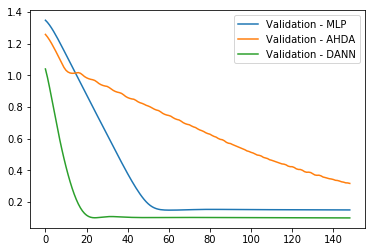

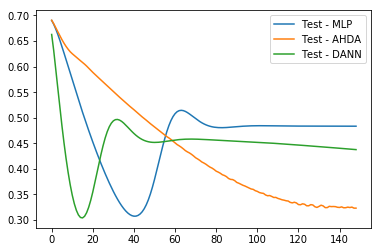

In [10]:
plt.figure(figsize=(6,4))
for m in ['MLP', 'AHDA', 'DANN']:
    plt.plot(full_logs[m][1][1:], label='Validation - '+m)
plt.legend()
plt.savefig('./plots/friedman/validation_curves_2.jpg', transparent=True)
plt.show()

plt.figure(figsize=(6,4))
for m in ['MLP', 'AHDA', 'DANN']:
    plt.plot(full_logs[m][2][1:], label='Test - '+m)
plt.legend()
plt.savefig('./plots/friedman/test_curves_2.jpg', transparent=True)
plt.show()


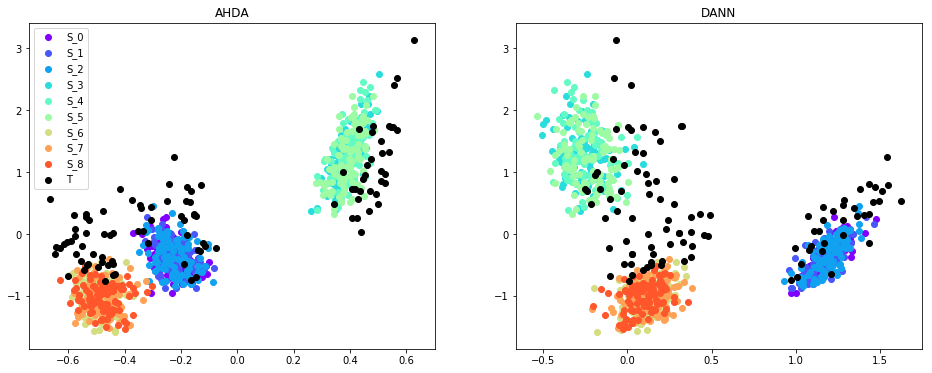

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
m='AHDA'
z = full_feats[m]
w = full_w[m].cpu().detach().numpy()[0][0]
color=iter(cm.rainbow(np.linspace(0,1,n_domains)))
for i in range(n_domains):
    c=next(color)
    if i<9:
        plt.scatter(z[i,:,1], y[i,:], c=c, label='S_'+str(i))
    else:
        plt.scatter(z[i,:,1], y[i,:], c='k', label='T')
plt.title(m)
plt.legend()

plt.subplot(1,2,2)
m='DANN'
z = full_feats[m]
w = full_w[m].cpu().detach().numpy()[0][0]
color=iter(cm.rainbow(np.linspace(0,1,n_domains)))
for i in range(n_domains):
    c=next(color)
    if i<9:
        plt.scatter(z[i,:,1], y[i,:], c=c, label='S_'+str(i))
    else:
        plt.scatter(z[i,:,1], y[i,:], c='k', label='T')
plt.title(m)
plt.savefig('./plots/ssda_extracted_features.jpg')
plt.show()

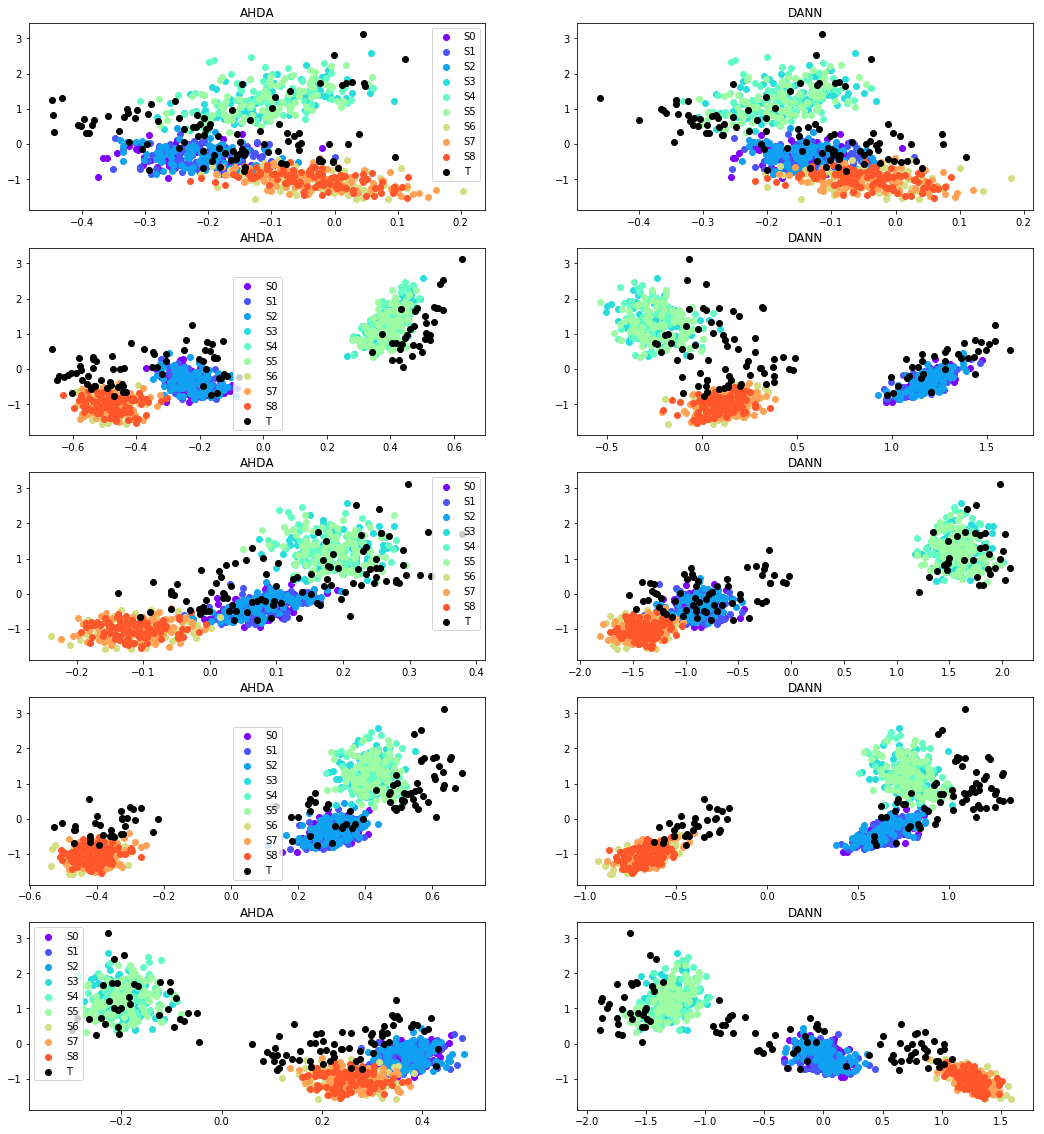

In [12]:
plt.figure(figsize=(18,20))

for f in range(5):
    plt.subplot(5,2,f*2+1)
    m='AHDA'
    z = full_feats[m]
    w = full_w[m].cpu().detach().numpy()[0][0]
    color=iter(cm.rainbow(np.linspace(0,1,n_domains)))
    for i in range(n_domains):
        c=next(color)
        if i<9:
            plt.scatter(z[i,:,f], y[i,:], c=c, label='S'+str(i))
        else:
            plt.scatter(z[i,:,f], y[i,:], c='k', label='T')
    plt.title(m)
    plt.legend()

    plt.subplot(5,2,f*2+2)
    m='DANN'
    z = full_feats[m]
    w = full_w[m].cpu().detach().numpy()[0][0]
    color=iter(cm.rainbow(np.linspace(0,1,n_domains)))
    for i in range(n_domains):
        c=next(color)
        if i<9:
            plt.scatter(z[i,:,f], y[i,:], c=c, label='S'+str(i))
        else:
            plt.scatter(z[i,:,f], y[i,:], c='k', label='T')
    plt.title(m)
plt.savefig('./plots/friedman/extracted_features.jpg', transparent = True)
plt.show()


In [80]:
score = []

for shift in np.arange(1.1,step=0.1):
    res_s = []
    print('-------------- ' + str(shift) + '--------------')
    N = 100
    n_domains = 10
    X = np.zeros((n_domains, N, 5))
    alpha = np.ones(n_domains-1)/(n_domains-1)

    X = generate_x_friedman(n_domains = 10, N = 100, alpha = np.ones(9)/9, noise=0.2,
                            target_shift_mean=shift, target_shift_std=0, random_state = 0)
    y = generate_y_friedman(X, normalize = True, random_state = 0)


    mode = 'No-adapt'
    seed = 0
    #Set seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    #Parameters of training
    epochs = 100
    device = torch.device('cuda:0')
    lr, momentum = 0.01, 0.9
    batch_size = 32
    keep_best = True
    print('----No-adapt----')

    #Model
    params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
             'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
    params['feature_extractor'] = get_feature_extractor()
    params['h_pred'] = get_predictor(output_dim=1)
    params['h_disc'] = get_discriminator(output_dim=1)
    clip = 1
    target = n_domains - 1

    #Split source and target
    X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
    #Validation split
    X_train, X_val, y_train, y_val = val_split(X_s, y_s)
    model = Disc_MSDANet(params).to(device)
    opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
    opt_pred = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
    opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
    opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
    model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
    #Logs
    reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
    current_val_loss = np.inf
    for epoch in range(epochs):
        model.train()
        loader = batch_loader(X_train, y_train ,batch_size = batch_size)
        for x_bs, y_bs in loader:
            loss_pred = model.train_prediction(x_bs, X_t, y_bs, clip=clip, pred_only=False)
            #model.train_h_disc_pred(x_bs, X_t, y_bs, clip=clip)
        #Validation
        model.eval()
        val_loss, _ = model.compute_loss(X_val, X_t, y_val)
        source_loss, disc = model.compute_loss(X_s, X_t, y_s)
        reg_loss = model.loss(y_t, model.predict(X_t))
        reg_train_loss.append(source_loss.item())
        reg_test_loss.append(reg_loss.item())
        reg_val_loss.append(val_loss.item())

        if (val_loss.item()<current_val_loss)*(keep_best):
            current_val_loss = val_loss.item()
            best_mse = model.loss(y_t, model.predict(X_t))
        if (epoch+1)%10==0:
            model.eval()
            print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs, source_loss.item(), val_loss.item(), reg_loss.item()))

    full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
    full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
    full_w[mode] = list(model.h_pred.parameters())[0]
    res_s.append(reg_loss.item())

    mode = 'Adapt'
    #Set seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True

    #Parameters of training
    epochs_adapt = 100
    epochs_h_disc, epochs_feat, epochs_pred = 1, 1, 1
    device = torch.device('cuda:0')
    lr, momentum = 0.01, 0.9
    batch_size = 32
    keep_best = True

    #Model
    params= {'input_dim': 5, 'output_dim': 1, 'n_sources': 9, 'loss': torch.nn.MSELoss(),
             'weighted_loss': weighted_mse, 'min_pred': -np.inf, 'max_pred':np.inf}
    params['feature_extractor'] = get_feature_extractor()
    params['h_pred'] = get_predictor(output_dim=1)
    params['h_disc'] = get_discriminator(output_dim=1)
    clip = 1
    target = n_domains - 1

    disc_adapt = []

    #Split source and target
    X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
    #Validation split
    X_train, X_val, y_train, y_val = val_split(X_s, y_s)
    model = Disc_MSDANet(params).to(device)
    opt_feat = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
    opt_pred = torch.optim.SGD([{'params': model.feature_extractor.parameters()}],lr=lr, momentum=momentum)
    opt_disc =torch.optim.SGD([{'params': model.h_disc.parameters()}],lr=lr, momentum=momentum)
    opt_alpha =torch.optim.SGD([{'params': model.alpha}],lr=lr, momentum=momentum)
    model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha)
    #Logs
    reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
    current_val_loss = np.inf
    #Alternated training
    print('----HDisc----')
    for epoch in range(epochs_adapt):
        model.train()
        loader = batch_loader(X_s, y_s ,batch_size = batch_size)
        for x_bs, y_bs in loader:
            ridx = np.random.choice(X_t.shape[0], batch_size)
            x_bt = X_t[ridx,:]
            #Train h to minimize source loss
            for e in range(epochs_pred):
                model.train_prediction(x_bs, x_bt, y_bs, pred_only=False,clip=clip)

            #Train h' to maximize discrepancy
            for e in range(epochs_h_disc):
                model.train_h_discrepancy(x_bs, x_bt, y_bs, clip=clip)

            #Train phi to minimize discrepancy
            for e in range(epochs_feat):
                model.train_feat_discrepancy(x_bs, x_bt, y_bs, mu=0,clip=clip)


        #Validation
        model.eval()
        val_loss, _ = model.compute_loss(X_val, X_t, y_val)
        source_loss, disc = model.compute_loss(X_s, X_t, y_s)
        reg_loss = model.loss(y_t, model.predict(X_t))
        reg_train_loss.append(source_loss.item())
        reg_test_loss.append(reg_loss.item())
        reg_val_loss.append(val_loss.item())
        disc_adapt.append(disc.item())
        if (val_loss.item()<current_val_loss)*(keep_best):
            current_val_loss = val_loss.item()
            best_mse = model.loss(y_t, model.predict(X_t))
        if (epoch+1)%10==0:
            model.eval()
            print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), reg_loss.item()))

    full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
    full_feats[mode] = np.array([model.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
    full_w[mode] = list(model.h_pred.parameters())[0]
    res_s.append(reg_loss.item())



    from models.MDAN import MDANet_general
    import torch.nn.functional as F
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    print('----DANN----')
    mode = 'DANN'

    configs = {"num_epochs": 100, "num_domains": 9, 
               "mode": 'DANN', "verbose": 2}

    epochs_h_disc, epochs_feat, epochs_pred = 1, 1, 1
    device = torch.device('cuda:0')
    lr, momentum = 0.01, 0.9
    batch_size = 32
    keep_best = True


    #Number of epochs
    epochs = 100
    device = torch.device('cuda:0')
    lr = 0.01
    batch_size = 32

    #Hyperparameters
    mu = 0.01
    gamma = 5
    mode = configs['mode']
    #Split source and target
    X_s, X_t, y_s, y_t = split_source_target(X, y, target, device, merge=False)
    #Validation split
    X_train, X_val, y_train, y_val = val_split(X_s, y_s)
    #Initialize model
    configs['hiddens'] = get_feature_extractor()
    configs['predictor'] = get_predictor(output_dim=1)
    configs['discriminator'] = [get_discriminator(output_dim=2) for _ in range(configs['num_domains'])]
    mdan = MDANet_general(configs).to(device)
    reg_train_loss, reg_val_loss, reg_test_loss = [], [], []
    current_val_loss = np.inf
    #Alternated training
    for i in range(configs['num_domains']):
        mdan.discriminator[i].to(device)
    optimizer = torch.optim.SGD(mdan.parameters(), lr=lr, momentum=momentum)
    for epoch in range(epochs):
        mdan.train()
        loader = batch_loader(X_train, y_train ,batch_size = batch_size)
        for x_bs, y_bs in loader:
            slabels = torch.ones(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
            tlabels = torch.zeros(batch_size, requires_grad=False).type(torch.LongTensor).to(device)
            ridx = np.random.choice(X_t.shape[0], batch_size)
            #Batch selection of X_t
            tinputs = X_t[ridx, :]
            optimizer.zero_grad()
            vals, sdomains, tdomains = mdan(x_bs, tinputs)
            # Compute prediction accuracy on multiple training sources.
            losses = torch.stack([F.mse_loss(vals[j], y_bs[j]) for j in range(configs['num_domains'])])
            domain_losses = torch.stack([F.nll_loss(sdomains[j], slabels) +
                                       F.nll_loss(tdomains[j], tlabels) for j in range(configs['num_domains'])])
            # Different final loss function depending on different training modes.
            loss = torch.mean(losses) + mu * torch.mean(domain_losses)
            loss.backward(retain_graph=True)
            optimizer.step()
        mdan.eval()
        preds_labels = mdan.inference(X_t)
        source_loss = torch.mean(torch.stack([torch.nn.MSELoss()(y_train[i], mdan.inference(X_train[i])) for i in range(len(y_train))]))
        val_loss = torch.mean(torch.stack([torch.nn.MSELoss()(y_val[i], mdan.inference(X_val[i])) for i in range(len(y_val))]))
        test_loss = torch.nn.MSELoss()(y_t, preds_labels)
        reg_train_loss.append(source_loss)
        reg_test_loss.append(test_loss)
        reg_val_loss.append(val_loss)

        if (epoch+1)%10==0:
            mdan.eval()
            print('Epoch: %i/%i ; Train loss: %.3f ; Validation loss: %.3f Test loss: %.3f'%(epoch+1, epochs_adapt, source_loss.item(), val_loss.item(), test_loss.item()))
    full_logs[mode] = [reg_train_loss, reg_val_loss, reg_test_loss]
    full_feats[mode] = np.array([mdan.extract_features(torch.Tensor(X[i]).to(device)).cpu().detach().numpy() for i in range(n_domains)])
    full_w[mode] = list(mdan.predictor.parameters())[0]
    res_s.append(test_loss.item())
    
    score.append(res_s)

-------------- 0.0--------------
----No-adapt----
Epoch: 10/100 ; Train loss: 0.475 ; Validation loss: 0.476 Test loss: 0.453
Epoch: 20/100 ; Train loss: 0.333 ; Validation loss: 0.342 Test loss: 0.274
Epoch: 30/100 ; Train loss: 0.259 ; Validation loss: 0.255 Test loss: 0.237
Epoch: 40/100 ; Train loss: 0.223 ; Validation loss: 0.202 Test loss: 0.210
Epoch: 50/100 ; Train loss: 0.209 ; Validation loss: 0.180 Test loss: 0.207
Epoch: 60/100 ; Train loss: 0.204 ; Validation loss: 0.170 Test loss: 0.206
Epoch: 70/100 ; Train loss: 0.199 ; Validation loss: 0.164 Test loss: 0.201
Epoch: 80/100 ; Train loss: 0.195 ; Validation loss: 0.160 Test loss: 0.195
Epoch: 90/100 ; Train loss: 0.191 ; Validation loss: 0.156 Test loss: 0.190
Epoch: 100/100 ; Train loss: 0.187 ; Validation loss: 0.152 Test loss: 0.185
----HDisc----
Epoch: 10/100 ; Train loss: 0.343 ; Validation loss: 0.351 Test loss: 0.284
Epoch: 20/100 ; Train loss: 0.243 ; Validation loss: 0.256 Test loss: 0.215
Epoch: 30/100 ; Train l

In [81]:
df = pd.DataFrame(data=score, index = np.arange(1.1,step=0.1), columns=['No-adapt', 'HDisc', 'DANN'])
df

,No-adapt,HDisc,DANN
0.0,0.185435,0.156535,0.206118
0.1,0.189858,0.151385,0.223474
0.2,0.245185,0.186751,0.298839
0.3,0.352157,0.256073,0.432488
0.4,0.506934,0.355930,0.619819
0.5,0.696460,0.515336,0.846734
0.6,0.921534,0.707204,1.111822
0.7,1.171415,0.928983,1.400938
0.8,1.423243,1.100808,1.683999
0.9,1.704777,1.332517,1.976735


In [46]:
df.to_csv('./results/ssda_friedman.csv')